In [0]:
classes = ['basketball',
 'pillow',
 'scissors',
 't-shirt',
 'tooth',
 'alarm_clock',
 'paper_clip',
 'spoon',
 'microphone',
 'candle']

In [0]:
!mkdir data

In [0]:
import urllib.request
def download():
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [0]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/basketball.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pillow.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/scissors.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/t-shirt.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tooth.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/alarm%20clock.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/paper%20clip.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/spoon.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/microphone.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/candle.npy


In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from sklearn.model_selection import train_test_split

def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    x_train, y_train, x_test, y_test = train_test_split(x/255,y, test_size=vfold_ratio)

    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, x_test, y_train, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28
print(len(x_train), x_train.shape, x_test.shape)

32000 (32000, 784) (8000, 784)


In [0]:
# Reshape and normalize
x_train = x_train.reshape(len(x_train), image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(len(x_test), image_size, image_size, 1).astype('float32')

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Convolution2D, MaxPooling2D, Dense

model = Sequential()

#layers
model.add(Convolution2D(6, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

adam = tf.train.AdamOptimizer()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])

model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 6)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        1760      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 32)          0        

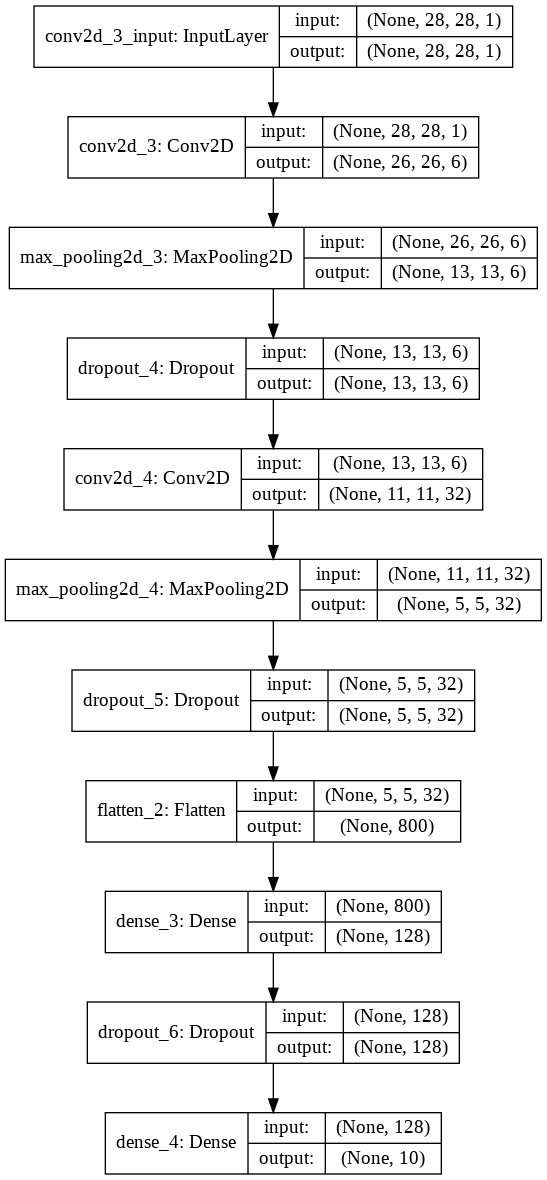

In [0]:
#Lets check the architecture out
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [0]:
history = model.fit(x = x_train, y = y_train, validation_split=0.2, batch_size = 256, verbose=2, epochs=5)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 22400 samples, validate on 9600 samples
Epoch 1/5





 - 9s - loss: 1.4945 - top_k_categorical_accuracy: 0.8798 - val_loss: 0.8766 - val_top_k_categorical_accuracy: 0.9548
Epoch 2/5
 - 8s - loss: 0.9450 - top_k_categorical_accuracy: 0.9533 - val_loss: 0.7034 - val_top_k_categorical_accuracy: 0.9682
Epoch 3/5
 - 8s - loss: 0.8004 - top_k_categorical_accuracy: 0.9638 - val_loss: 0.6057 - val_top_k_categorical_accuracy: 0.9719
Epoch 4/5
 - 8s - loss: 0.7225 - top_k_categorical_accuracy: 0.9676 - val_loss: 0.5320 - val_top_k_categorical_accuracy: 0.9747
Epoch 5/5
 - 8s - loss: 0.6656 - top_k_categorical_accuracy: 0.9700 - val_loss: 0.5067 - val_top_k_categorical_accuracy: 0.9749


In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 97.91%


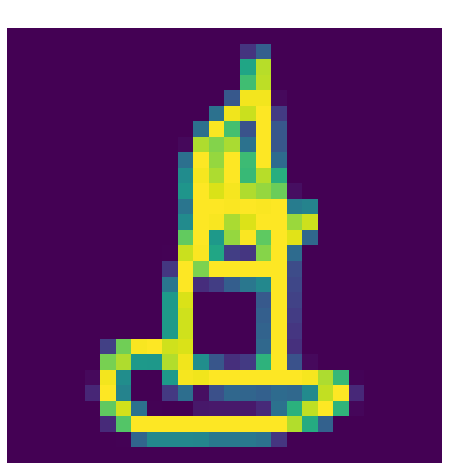

In [0]:
#Plot a random image from the test set and predict it's label.
#This is basically the model live in action.
import matplotlib.pyplot as plt
import random

index = random.randint(0, len(x_test))

prediction = model.predict(x_test[index].reshape(-1,28,28,1))
plt.figure(figsize=(8,8))
plt.imshow(x_test[index].squeeze())
plt.title(class_names[np.argmax(prediction)], color='white', fontsize=20)
plt.axis('off')
plt.show()

In [0]:
#Let's try visualizing a part of what the CNN in its hidden layers
from keras import backend as K

get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[0].output])
layer_output = get_3rd_layer_output([x_test[5012].reshape(-1,28,28,1)])[0]

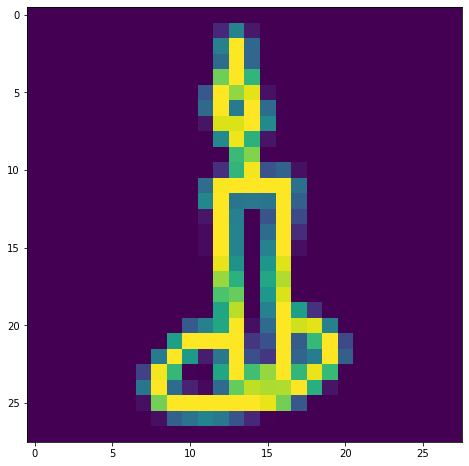

In [0]:
#Input image
plt.figure(figsize=(8,8))

plt.imshow(x_test[5012].squeeze())

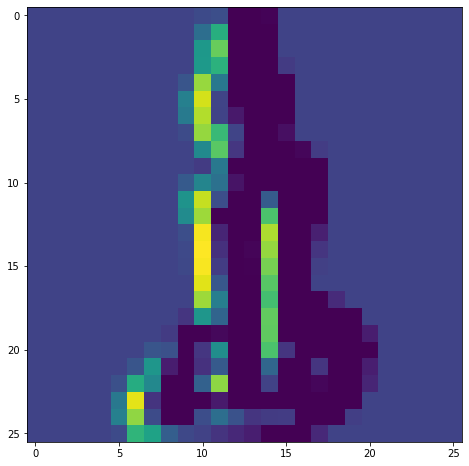

In [0]:
#4D tensor with shape: (batch, 26*26 feature map, channels)
#visualize the channel, in this case number 4.
plt.figure(figsize=(8,8))
plt.imshow(layer_output[0, :,:,4])

In [0]:
#Dive a few layers deeper
from keras import backend as K

get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output_2 = get_3rd_layer_output([x_test[5012].reshape(-1,28,28,1)])[0]

get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[4].output])
layer_output_3 = get_3rd_layer_output([x_test[5012].reshape(-1,28,28,1)])[0]
print(layer_output_2.shape, layer_output_3.shape)

(1, 13, 13, 6) (1, 5, 5, 32)


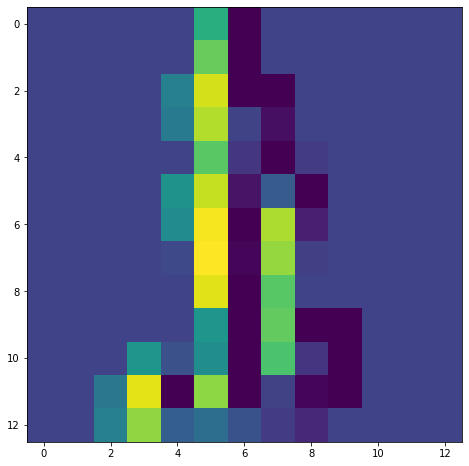

In [0]:
plt.figure(figsize=(8,8))
plt.imshow(layer_output_2[0, :,:,4])

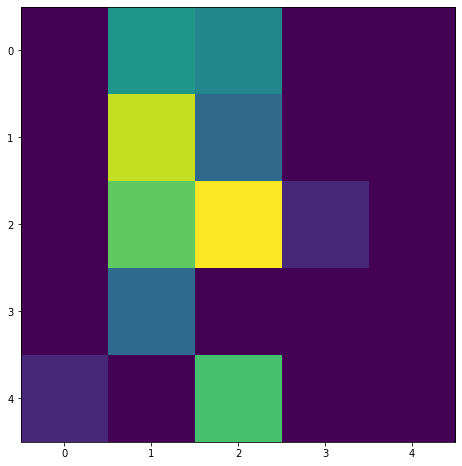

In [0]:
plt.figure(figsize=(8,8))
plt.imshow(layer_output_3[0, :,:,4])

In [0]:
#save as normal keras model
model.save('keras.h5')
from google.colab import files
files.download("keras.h5")

#save as a tflite model for on-device
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model_file( 'keras.h5')
tfmodel = converter.convert()
open("converted_model.tflite", "wb").write(tfmodel)
files.download("converted_model.tflite")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:135: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


# Just for fun, lets try a KNN classifier

In [0]:
print(y_train.shape)
#KNN classifier expects a 2D array and not a 4D array compared to the CNN
knn_x_train = x_train.reshape((32000, 28*28))
knn_x_test = x_test.reshape((8000, 28*28))
print(knn_x_train.shape, knn_x_test.shape)

knn_y_train = y_train.reshape(32000, 10)
knn_y_test = y_test.reshape(8000, 10)

print(knn_y_train.shape, knn_y_test.shape)

(32000, 10)
(32000, 784) (8000, 784)
(32000, 10) (8000, 10)


In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn = KNeighborsClassifier()
knn.fit(knn_x_train, knn_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
#store predictions on x_test data
knn_pred = knn.predict(knn_x_test)

In [0]:
#compare predictions to actual
print('knn accuracy score:',metrics.accuracy_score(knn_y_test,knn_pred))

knn accuracy score: 0.80975
